In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import sys, time
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from aux import LogSumExp

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

In [104]:
def lqN(x,rho,u,N,lq0,L,epsilon,grad_lp,xi=np.pi/16):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    if N==0: return lq0(x_,rho_,u_)
    w=np.zeros((N,x_.shape[1]))
    w[0,:]=lq0(x_,rho_,u_)
    lJ=np.zeros(x_.shape[1])
    for n in range(N):
        print(x_[0,0])
        print(rho_[0,0])
        x_,rho_,u_,tlJ,_,_,_=flow(1,x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')
        lJ=lJ+tlJ
        print(tlJ[0])
        print(lJ[0])
        w[n,:]=lq0(x_,rho_,u_)-tlJ
        print(np.exp(w[n,0]))
        print(np.sum(np.exp(w[:n,0])))
        print()
    # end for
    return LogSumExp(w)-np.log(N),x_

def randqN(size,N,randq0,L,epsilon,grad_lp,xi=np.pi/16):
    if N==1: return randq0(size)
    K=np.random.randint(low=0,high=N,size=size)
    lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm # laplacian momentum
    x,rho,u=randq0(size)
    print(u.shape)
    for n in range(N):
        tx,trho,tu,_,_,_,_=flow(1,x[:,K>=n+1],rho[:,K>=n+1],u[K>=n+1],L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,'fwd') # update those with large enough K
        x[:,K>=n+1]=tx
        rho[:,K>=n+1]=trho
        u[K>=n+1]=tu
    # end for
    return x,rho,u
    


def flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction):
    x_,rho_,u_=np.copy(x),np.copy(rho),np.copy(u)
    lJ=np.zeros(x_.shape[1])
    if steps==0: return x_,rho_,u_,lJ
    
    # CACHEING FOR DEBUGGING
    xs=np.zeros((steps+1,x.shape[0],x.shape[1]))
    xs[0,:,:]=x_
    rhos=np.zeros((steps+1,rho.shape[0],rho.shape[1]))
    rhos[0,:,:]=rho_
    us=np.zeros((steps+1,u.shape[0]))
    us[0,:]=u_
    ###
    for n in range(steps):
        #print(str(n+1)+'/'+str(steps),end='\r')
        if direction=='fwd': x_,rho_,u_,tmplJ=forward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        if direction=='bwd': x_,rho_,u_,tmplJ=backward(x_,rho_,u_,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi)
        lJ=lJ+tmplJ
        
        # CACHEING FOR DEBUGGING
        xs[n+1,:,:]=x_
        rhos[n+1,:,:]=rho_
        us[n+1,:]=u_
        ###
    # end for
    return x_,rho_,u_,lJ,xs,rhos,us

def forward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_=Ham(x,rho,L,epsilon,grad_lp,grad_lm)
    lJ=lm(rho_)
    u_=(u+xi)%1
    rho_=Qm((Fm(rho_)+pseudo_random(x_,u_))%1)
    lJ=lJ-lm(rho_)
    return x_,rho_,u_,lJ

def backward(x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi):
    x_,rho_,u_=x,rho,u
    lJ=-lm(rho_)
    rho_=Qm((Fm(rho_)-pseudo_random(x_,u_))%1)
    lJ=lJ+lm(rho_)
    u_=(u_-xi)%1
    x_,rho_=Ham(x_,rho_,L,-epsilon,grad_lp,grad_lm)
    return x_,rho_,u_,lJ

def Ham(x,rho,L,epsilon,grad_lp,grad_lm):
    x_,rho_=np.copy(x),np.copy(rho)
    for l in range(L):
        rhot = rho_  + epsilon*grad_lp(x_)/2
        x_    = x_   - epsilon*grad_lm(rhot)
        rho_  = rhot + epsilon*grad_lp(x_)/2
    # end for
    return x_,rho_

def lap_lm(rho): return -np.sum(np.abs(rho),axis=0)-rho.shape[0]*np.log(2) #(M,d)->(d,)
def lap_Fm(rho): return 0.5-0.5*np.sign(rho)*np.expm1(-np.abs(rho))#(1-np.exp(-np.abs(rho))) #(M,d)->(M,d)
def lap_Qm(p)  : return -np.sign(p-0.5)*np.log1p(-2*np.abs(p-0.5)) #(M,d)->(M,d)
def lap_gradlm(rho): return -np.sign(rho) #(M,d)->(M,d)

def gauss_lp(x,mu,sigma): return -0.5*np.sum((x-mu)**2,axis=0)/sigma**2-x.shape[0]*np.log(2*np.pi*sigma**2)/2
def pseudo_random(x,u): return 0.5*np.sin(2*x+u)+0.5

In [110]:
# target specification
def lp(x): return gauss_lp(x,0,1)
def grad_lp(x): return -x

# ref specification
mu0=2
sigma0=0.3
def lq0(x,rho,u): return gauss_lp(x,mu0,sigma0)+lap_lm(rho)
def randq0(size): return mu0+sigma0*np.random.randn(1,size),np.random.laplace(size=(1,size)),np.random.rand(size)

ss=1000
q0_sample=mu0+sigma0*np.random.randn(1,ss)

In [100]:
size=1000
x=np.linspace(-4,4,size)[np.newaxis,:]
#x=np.random.randn(1,size)
rho=np.random.laplace(size=(1,size))
u=np.random.rand(size)
lq,newx=lqN(x,rho,u,N=100,lq0=lq0,L=50,epsilon=0.1,grad_lp=grad_lp,xi=np.pi/16)

-4.0
1.2930993968375089
0.6886347275942568
0.6886347275942568
4.2139387321753974e-08
0.0

0.8000000000000028
-7.885535330756738
6.530756106267888
7.219390833862144
6.214296429914826e-32
4.2139387321753974e-08

-1.3999999999999972
-0.6947792244888349
-0.6890453189743062
6.530345514887838
5.143235818005609e-05
4.2139387321753974e-08

0.8000000000000027
2.156175456536873
-0.6907480447098209
5.839597470178017
1.0158289115607557e-20
5.1474497567377845e-05

-0.799999999999997
-2.7630764987532936
-0.06142751337057506
5.778169956807442
1.4633730525540082e-05
5.147449756737785e-05

0.8000000000000027
2.7854959878761463
1.751654876930819
7.529824833738261
1.746069428634888e-18
6.610822809291794e-05

-0.5999999999999973
-1.1738411109453122
-0.28751658671297653
7.242308247025285
0.25389286068592565
6.610822809291969e-05

1.6000000000000032
0.36135769765830267
0.20554445227190077
7.447852699297186
2.7600442520080977e-13
0.2539589689140186

-0.19999999999999737
-1.4158132453863872
1.0416577040724686

(array([  3.,  10.,  38., 101., 208., 241., 222., 121.,  43.,  13.]),
 array([-3.56696697, -2.92484484, -2.28272272, -1.6406006 , -0.99847848,
        -0.35635636,  0.28576577,  0.92788789,  1.57001001,  2.21213213,
         2.85425425]),
 <BarContainer object of 10 artists>)

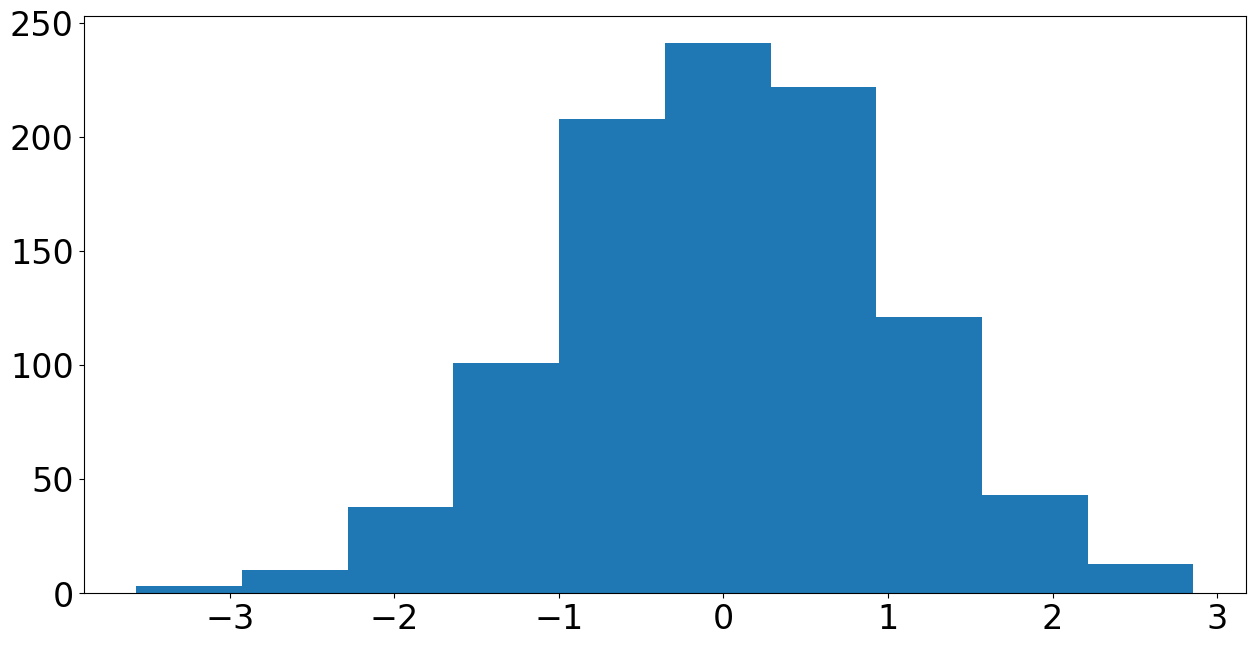

In [101]:
plt.hist(newx[0,:])

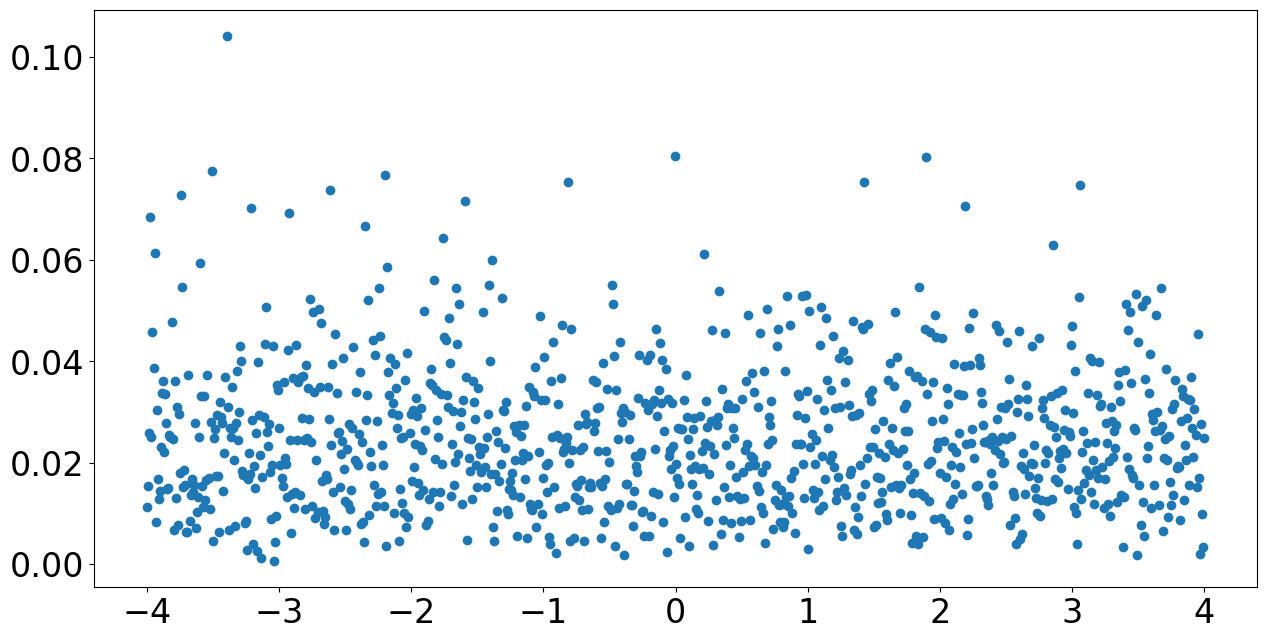

In [102]:
plt.scatter(x[0,:],np.exp(lq))

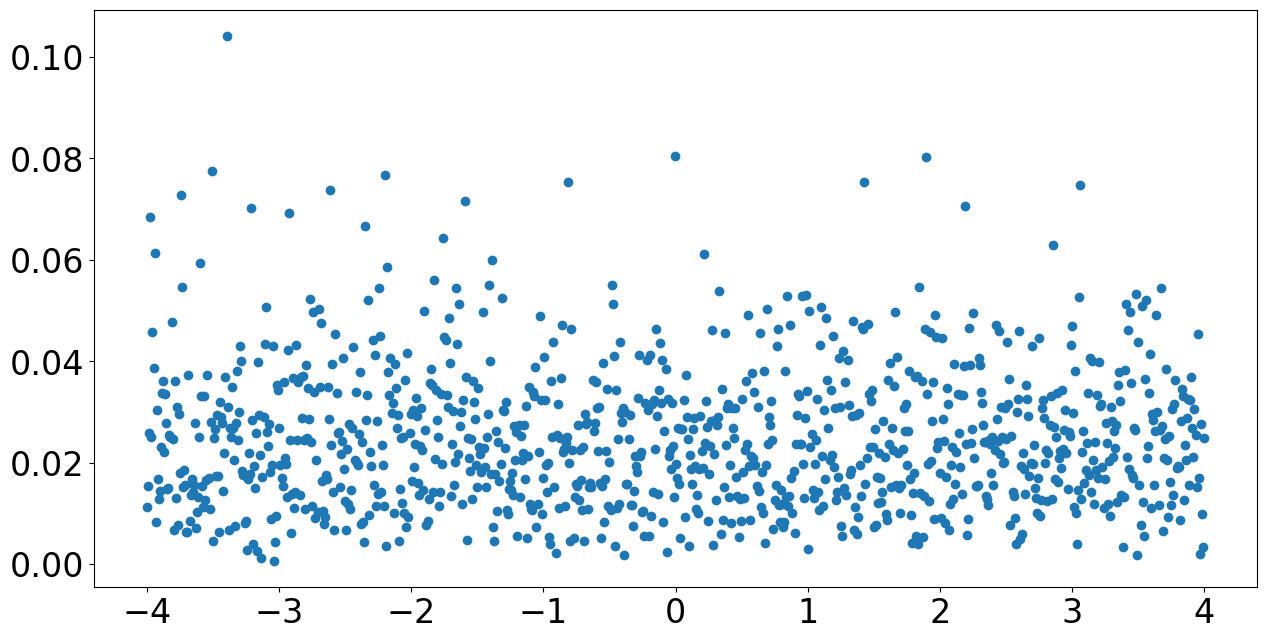

In [103]:
args=np.argsort(x[0,:])
plt.scatter(x[0,args],np.exp(lq[args]))

## Forward pass

In [8]:
# settings
steps=100
x=q0_sample
rho=np.random.laplace(size=(1,ss))
u=np.random.rand(ss)
L=50
epsilon=0.1
lm,Fm,Qm,grad_lm=lap_lm,lap_Fm,lap_Qm,lap_gradlm
xi=np.pi/16
direction='fwd'

In [9]:
xp,rhop,up,lJ,xs,rhos,us=flow(steps,x,rho,u,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction)

In [10]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

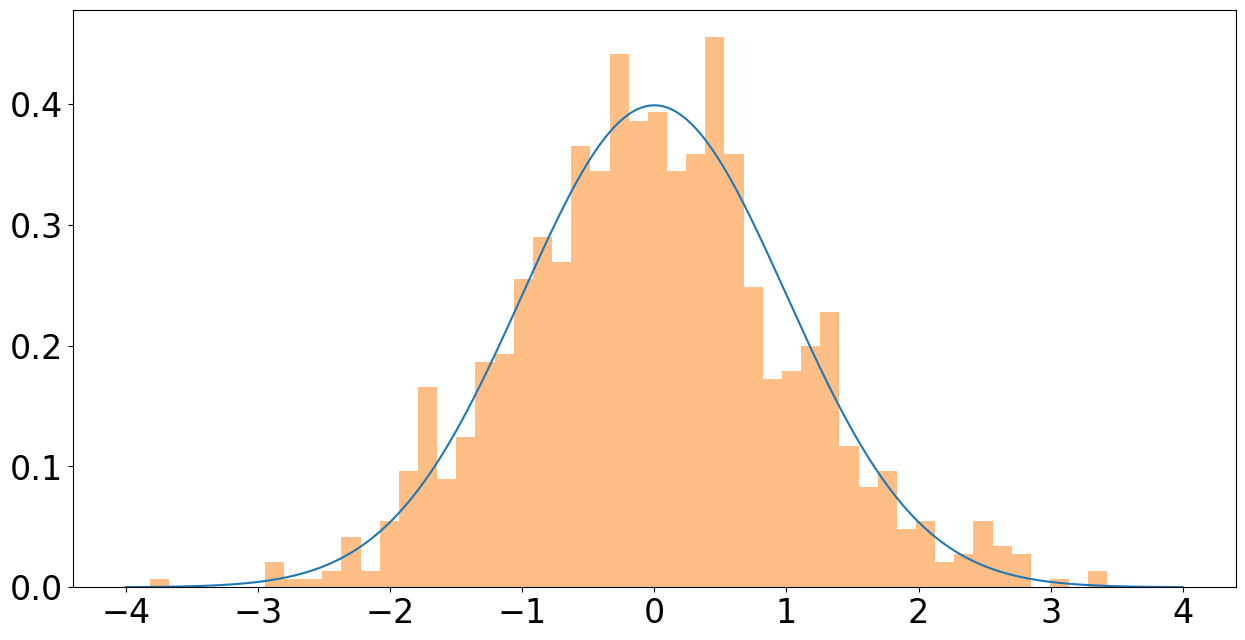

In [11]:
ttxp=np.linspace(-4,4,1000)
plt.plot(ttxp,np.exp(lp(ttxp[np.newaxis,:])))
plt.hist(xp[0,:],alpha=0.5,density=True,bins=50);

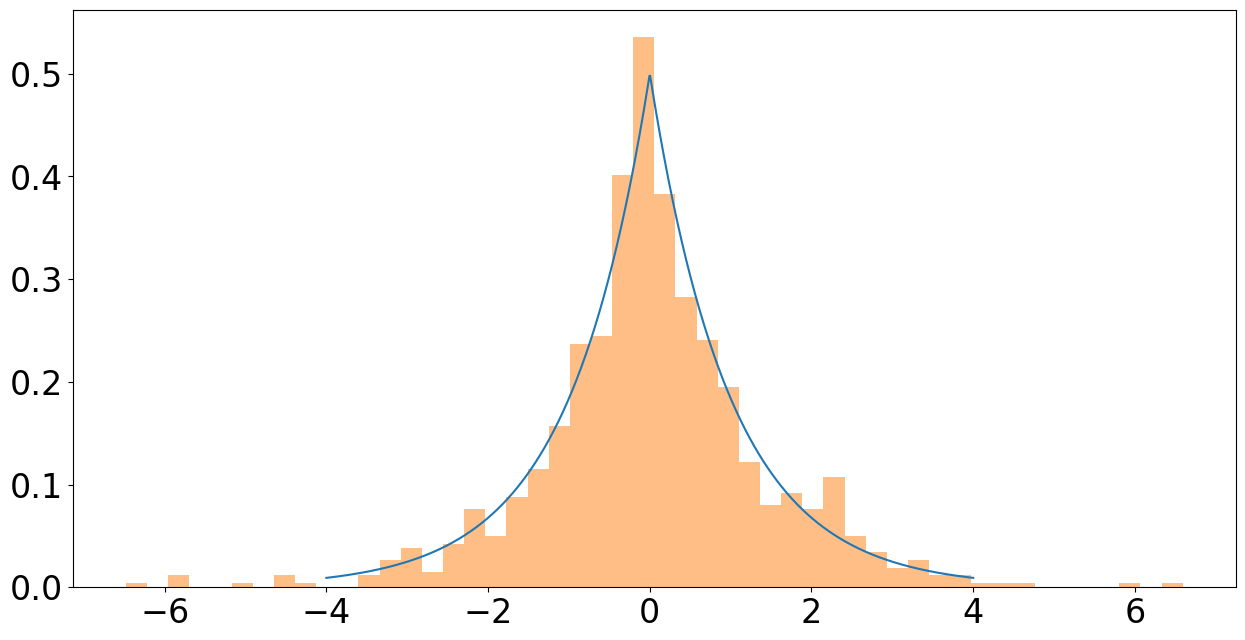

In [12]:
ttrho=np.linspace(-4,4,1000)
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhop[0,:],alpha=0.5,density=True,bins=50);

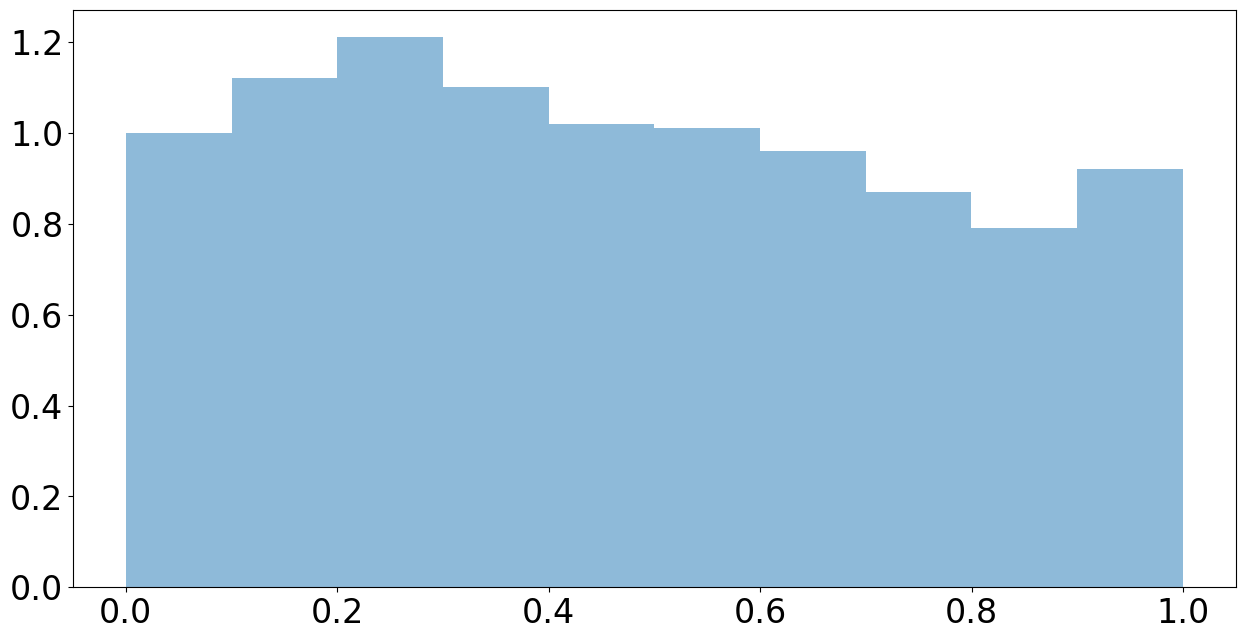

In [13]:
plt.hist(up,alpha=0.5,density=True,bins=10);

## Backward pass

In [14]:
xpp,rhopp,upp,lJ,xps,rhops,ups=flow(steps,xp,rhop,up,L,epsilon,grad_lp,lm,Fm,Qm,grad_lm,xi,direction='bwd')

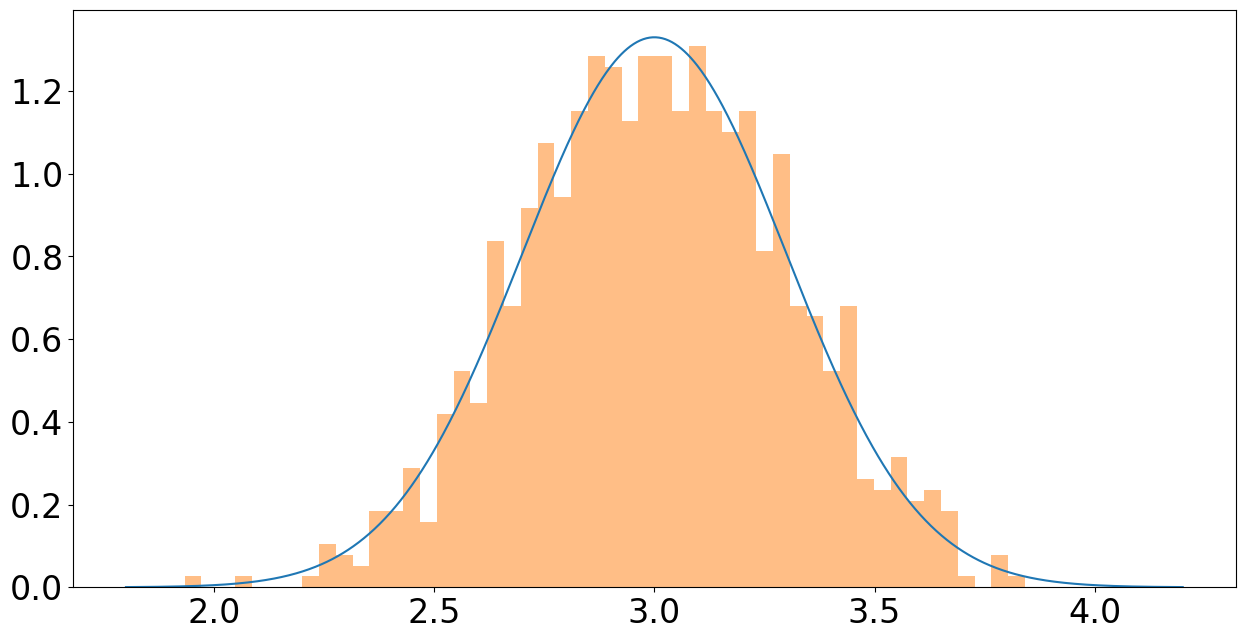

In [15]:
ttx=np.linspace(mu0-4*sigma0,mu0+4*sigma0,1000)
plt.plot(ttx,np.exp(gauss_lp(ttx[np.newaxis,:],mu0,sigma0)))
plt.hist(xpp[0,:],alpha=0.5,density=True,bins=50);

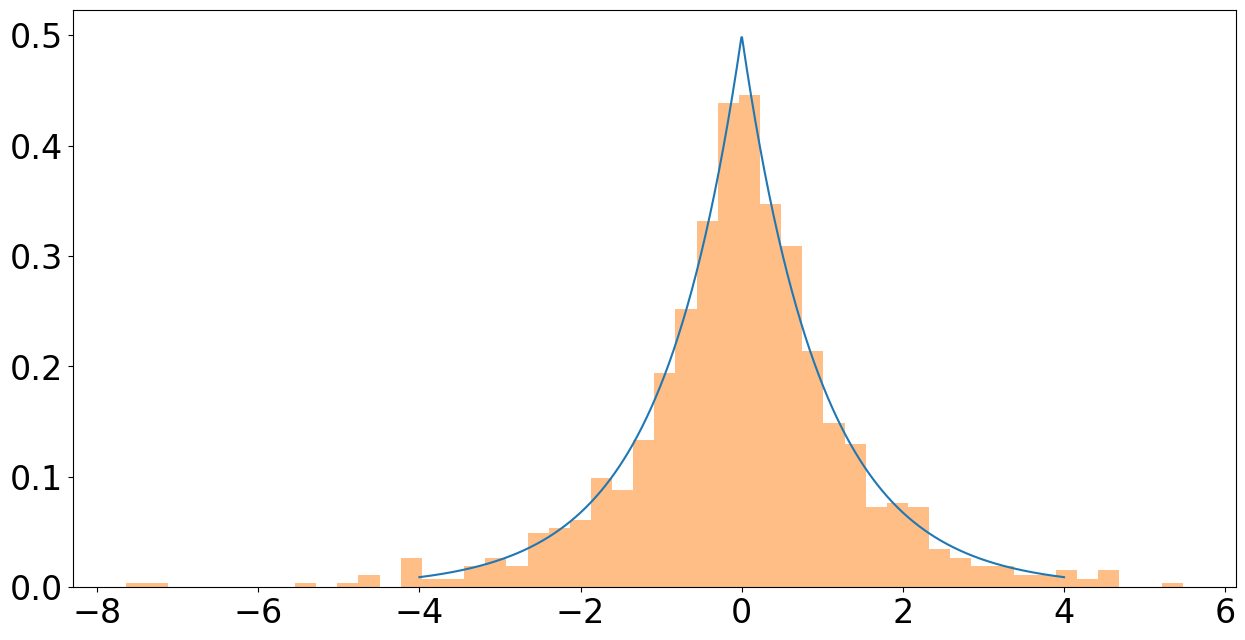

In [16]:
plt.plot(ttrho,np.exp(lap_lm(ttrho[np.newaxis,:])))
plt.hist(rhopp[0,:],alpha=0.5,density=True,bins=50);

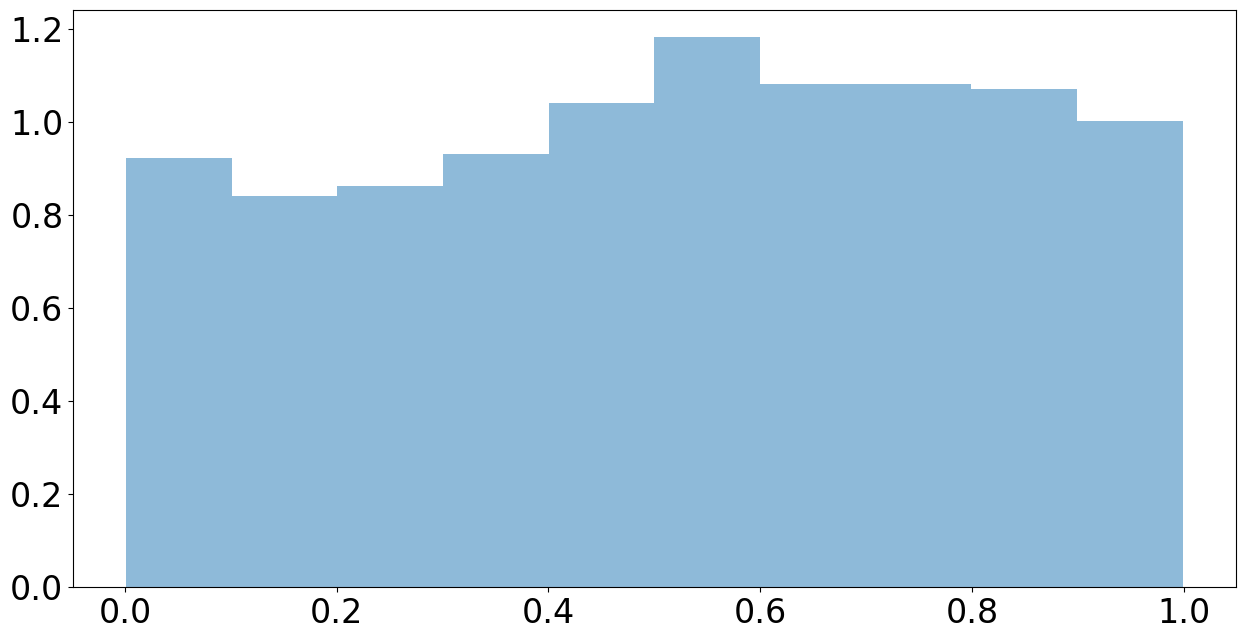

In [17]:
plt.hist(upp,alpha=0.5,density=True,bins=10);

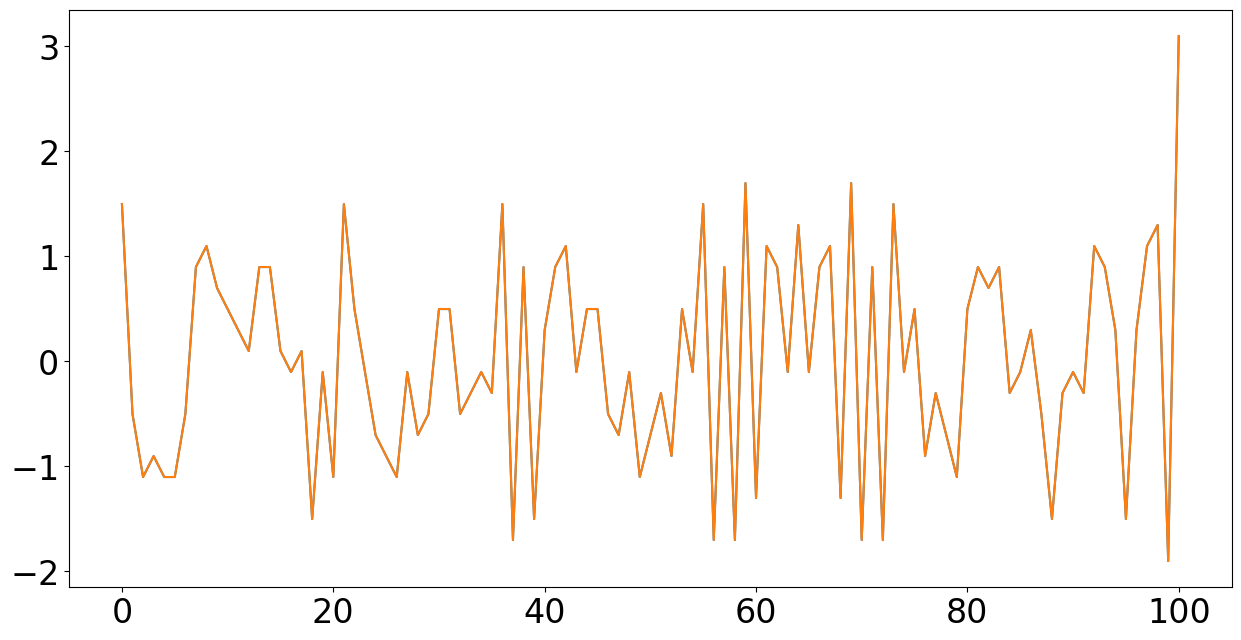

In [18]:
plt.plot(np.arange(0,steps+1),np.flip(xs[:,0,0]))
plt.plot(np.arange(0,steps+1),xps[:,0,0])

## Density

## Sampling

(1000,)


(array([ 10.,  29.,  71., 163., 236., 250., 136.,  80.,  21.,   4.]),
 array([-3.10373516, -2.4615428 , -1.81935043, -1.17715806, -0.5349657 ,
         0.10722667,  0.74941903,  1.3916114 ,  2.03380376,  2.67599613,
         3.31818849]),
 <BarContainer object of 10 artists>)

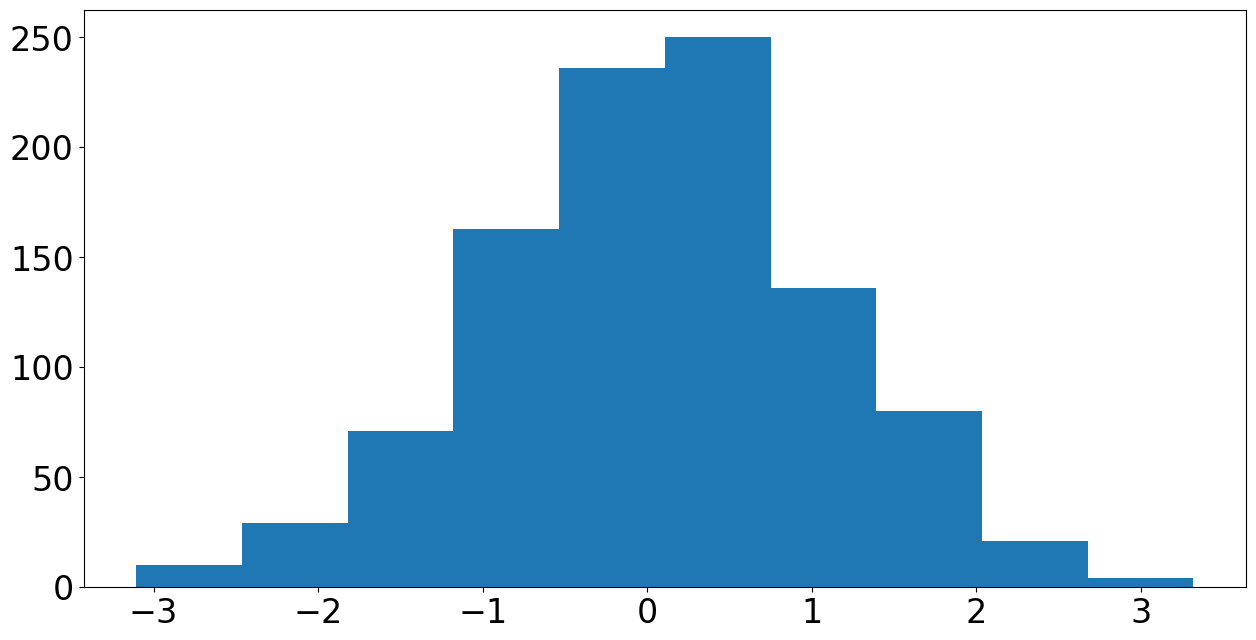

In [112]:
xx,rrho,uu=randqN(1000,100,randq0,L,epsilon,grad_lp,xi)
plt.hist(xx[0,:])